---
date: '2023-03-31'
description: Tutorial code of how I integrated Deep Supervision Loss generation setup with  Segmentation Models PyTorch Framework, which could be Directly us with Minimal changes
categories:
- Medical AI
- segmentation
- PyTorch
toc: true
output-file: deep-supervised-in-segmentation-models-pytorch.html
title: Integrating Deep Supervision in Segmentation Models Pytorch (smp)?
---

# In this Notebook -  I share my understanding and my Work related to Deep Supervision in Models and Loss Function, I feel Deep Supervision is Sometimes Useful in the cases where the segmentation part bit hard to get detected.

#### With my own understanding and thinking I try to implement Deep Supervision.
#### As it is conversion of SMP's Unet Code to Deep Supervision. . . I might have made mistakes, or maybe all of my work is a mess or may be its Evolutionary for Kaggle- Let me know in the comments.
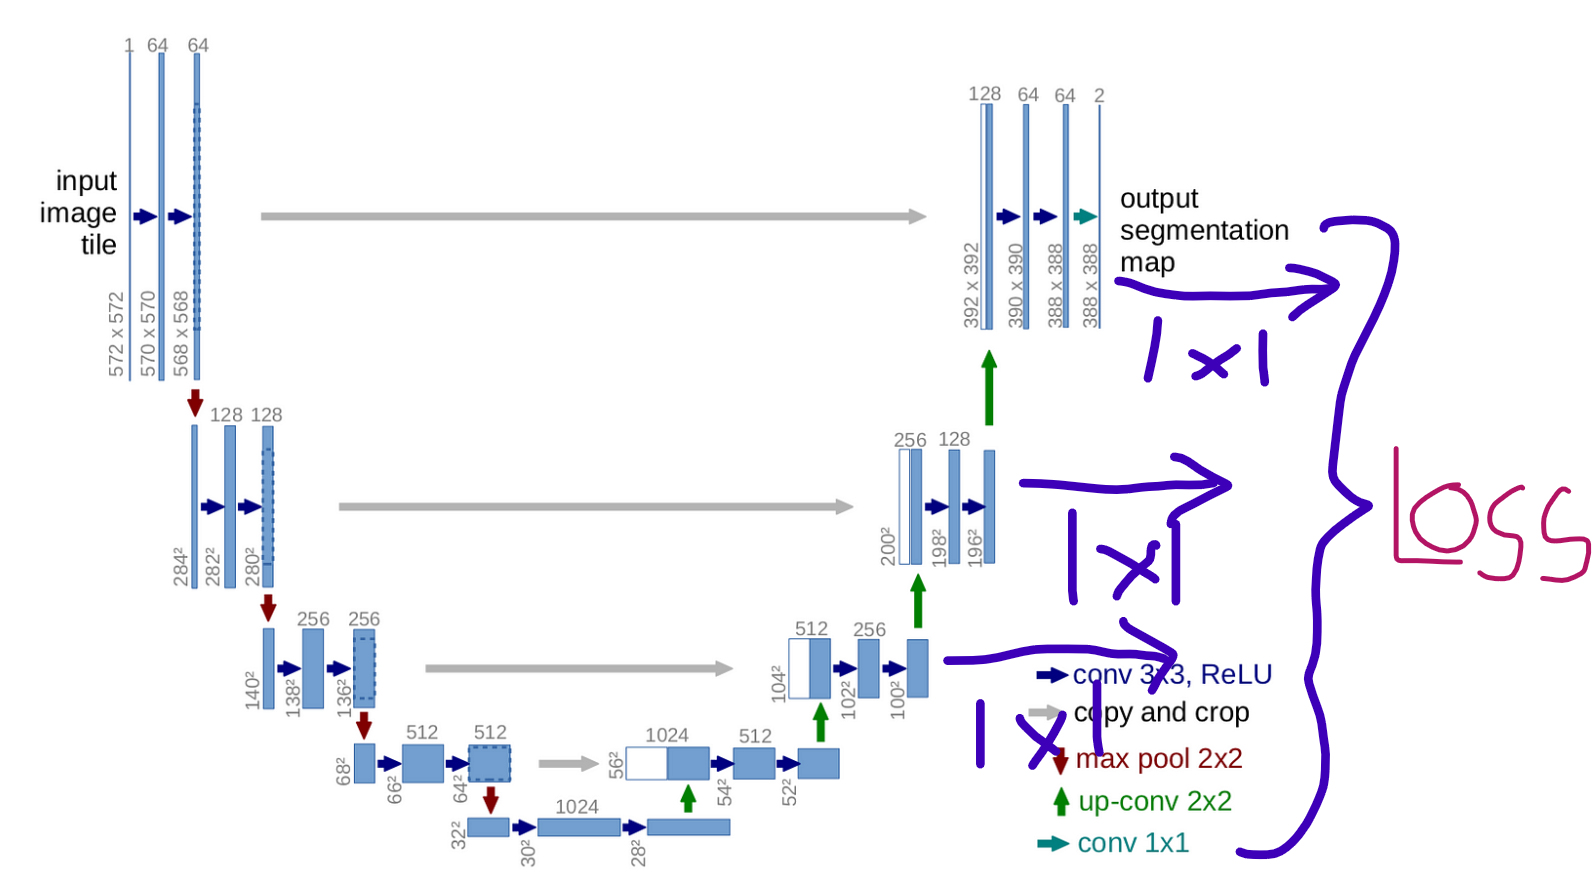


In [1]:
%%capture
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

## Here directly copied the Decoder code of Segmentation Model PyTorch Unet. And in the class UnetDecoder I simply also appended the outputs in the Decoder and Passed it also through different Segmentation heads according to their Channels.

### My Output basically goes from Larger Image (prediction) to smaller outputs of unet.

example : 

* torch.Size([1, 1, 384, 384])
* torch.Size([1, 1, 192, 192])
* torch.Size([1, 1, 96, 96])
* torch.Size([1, 1, 48, 48])
* torch.Size([1, 1, 24, 24])


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from segmentation_models_pytorch.base import modules as md
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base import (
    SegmentationModel,
    SegmentationHead,
    
)

import segmentation_models_pytorch as smp


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        skip_channels,
        out_channels,
        use_batchnorm=True,
        attention_type=None,
    ):
        super().__init__()
        self.conv1 = md.Conv2dReLU(
            in_channels + skip_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention1 = md.Attention(attention_type, in_channels=in_channels + skip_channels)
        self.conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        self.attention2 = md.Attention(attention_type, in_channels=out_channels)

    def forward(self, x, skip=None):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
            x = self.attention1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention2(x)
        return x


class CenterBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        conv1 = md.Conv2dReLU(
            in_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        conv2 = md.Conv2dReLU(
            out_channels,
            out_channels,
            kernel_size=3,
            padding=1,
            use_batchnorm=use_batchnorm,
        )
        super().__init__(conv1, conv2)


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels,
        n_blocks=5,
        use_batchnorm=True,
        attention_type=None,
        center=False,
    ):
        super().__init__()

        if n_blocks != len(decoder_channels):
            raise ValueError(
                "Model depth is {}, but you provide `decoder_channels` for {} blocks.".format(
                    n_blocks, len(decoder_channels)
                )
            )

        # remove first skip with same spatial resolution
        encoder_channels = encoder_channels[1:]
        # reverse channels to start from head of encoder
        encoder_channels = encoder_channels[::-1]

        # computing blocks input and output channels
        head_channels = encoder_channels[0]
        in_channels = [head_channels] + list(decoder_channels[:-1])
        skip_channels = list(encoder_channels[1:]) + [0]
        out_channels = decoder_channels

        if center:
            self.center = CenterBlock(head_channels, head_channels, use_batchnorm=use_batchnorm)
        else:
            self.center = nn.Identity()

        # combine decoder keyword arguments
        kwargs = dict(use_batchnorm=use_batchnorm, attention_type=attention_type)
        blocks = [
            DecoderBlock(in_ch, skip_ch, out_ch, **kwargs)
            for in_ch, skip_ch, out_ch in zip(in_channels, skip_channels, out_channels)
        ]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, *features):

        features = features[1:]  # remove first skip with same spatial resolution
        features = features[::-1]  # reverse channels to start from head of encoder

        head = features[0]
        skips = features[1:]

        x = self.center(head)

        out = []
        for i, decoder_block in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = decoder_block(x, skip)
            out.append(x)

        return out[::-1]
    

class SegmentationModel(nn.Module):
    def __init__(self, 
                encoder,
                encoder_weights=None,
                encoder_depth=5,
                in_channels=3,
                decoder_use_batchnorm: bool = True,
                decoder_channels = (256, 128, 64, 32, 16),
                decoder_attention_type = None,
                classes = 1
                 ):
        super().__init__()

        self.encoder = get_encoder(
            encoder,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
        )

        self.decoder = UnetDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=decoder_channels,
            n_blocks=encoder_depth,
            use_batchnorm=decoder_use_batchnorm,
            center=False,
            attention_type=decoder_attention_type,
        )

        self.segmentation_head = nn.ModuleList()
        for channel in decoder_channels[::-1]:
            self.segmentation_head.append(
                SegmentationHead(
                    in_channels=channel,
                    out_channels=classes,
                    activation=None,
                    kernel_size=3,
                )
            )

    def forward(self,x):

        features = self.encoder(x)
        decoder_output = self.decoder(*features)
        
        masks = []
        for i,seg_head in enumerate(self.segmentation_head):
            masks.append(seg_head(decoder_output[i]))

        return masks




in_ = torch.zeros((1,3,384,384))

model = SegmentationModel("resnet18")
model.to("cuda")

print("The following are the expected outputs")
for i in model(in_.to("cuda")):
    print(i.shape)


The following are the expected outputs
torch.Size([1, 1, 384, 384])
torch.Size([1, 1, 192, 192])
torch.Size([1, 1, 96, 96])
torch.Size([1, 1, 48, 48])
torch.Size([1, 1, 24, 24])


## This is My Custom Loss Function that takes output from all Decoder block and interpolates the Ground Truth(Labels/Targets) and calculates the loss.

### The "w" weight is actually 1/2^(index of input) according to which more importance is given to the Main Prediction and smaller and smaller weight is given to deeper Decoder outputs.

In [12]:
class Deep_Supervised_Loss(nn.Module):
    def __init__(self):

        super().__init__()
        self.loss = smp.losses.TverskyLoss(mode="binary",from_logits=False,)

    def forward(self, input, target):
        loss = 0
        # print(type(input))
        for i, img in enumerate(input):
            w = 1 / (2 ** i)
            
            label = F.interpolate(target,size=img.shape[2:])

            l = self.loss(torch.sigmoid(img), label)
            
            loss += l * w
            
        return loss     

## Good News is all SMP's and timm's Pretrained weight work here

In [26]:
ENCODER = "resnet18"
ENCODER_WEIGHTS = "imagenet"

### Only thing we need to take care is we must get Segmetation Model Class instead of smp.unet of library to use Deep Supervision

In [27]:
model = SegmentationModel(encoder=ENCODER,encoder_weights=ENCODER_WEIGHTS)

In [17]:
train_image = torch.randn((36,3,256,256),device="cuda")
train_labels = torch.ones((36,1,256,256),device="cuda")

In [20]:
model.to("cuda")
prediction = model(train_image)

##  Output is a List whose length is same as Encoder length 0'th index is the main Index of Prediction

In [28]:
print("look at the shape of Predictions")
for out in prediction:
    print(out.shape)

look at the shape of Predictions
torch.Size([36, 1, 256, 256])
torch.Size([36, 1, 128, 128])
torch.Size([36, 1, 64, 64])
torch.Size([36, 1, 32, 32])
torch.Size([36, 1, 16, 16])


## Implementation output of Loss Function

In [29]:
loss = Deep_Supervised_Loss()(prediction,train_labels)
print(loss.item())

0.6200616359710693
